### Simulation routine for figure 1

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from data_prep import load_data
from strategic import best_response
from optimization import logistic_regression, evaluate_loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Data 

We perform our experiments on the *Give me a credit* dataset available at https://www.kaggle.com/c/GiveMeSomeCredit. The dataset contains features of individuals and an indicator varaible on whether they defaulted on a loan or not.

In [7]:
# load data
X, Y, data = load_data('./cs-training.csv')
n = X.shape[0]
d = X.shape[1] - 1

Define a subset of features that can be modified strategically

In [8]:
strat_features = np.array([1, 6, 8]) - 1 # for later indexing

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


## 2) Simulation

### Initial ERM Classifier

We train a logistic regression classifier on the given set of features and labels. 
This corresponds to the classical supervised learning procedure.

In [9]:
# fit logistic regression model we treat as the truth
np.random.seed(2)
lam = 1.0/n
theta_true, loss_list, smoothness = logistic_regression(X, Y, lam, 'Exact')
strat_norm = np.linalg.norm(theta_true[strat_features])

print('Accuracy: ', ((X.dot(theta_true) > 0)  == Y).mean())
print('Loss: ', loss_list[-1])
print('Condition Number: ', lam / (smoothness + lam))
print('Norm: ', np.linalg.norm(theta_true))
print('Strat Features, Norm: ', theta_true[strat_features], strat_norm)

Accuracy:  0.7207059977120445
Loss:  0.609948675416671
Condition Number:  1.1674064432758537e-05
Norm:  2.4515844200763772
Strat Features, Norm:  [-0.0068505   0.01096926  0.09788595] 0.09873658927305824


### Repeated ERM

We simulate the effect of performativity. Therefore we perform `num_iters` rounds. In each round the following three steps are performed: i) we train an ERM classifier on the current set of features, ii) the classifier is deployed and iii) the individuals react strategically to the deployed calssifier, inducing a new set of fetaures for the next round

a) configure experiment

In [12]:
# problems parameters
num_iters  = 25
eps_list = [0.5]
eps = eps_list[0]
num_eps  = len(eps_list)


#####################
# NEW - CogLevels####

Alpha_list = [[0,0.9,0.1], [0,0.5,0.5], [0,0.1,0.9]]

def split_ind(n, alpha):
    agent_ind = []
    shuffled_ind = np.arange(n)
    np.random.shuffle(shuffled_ind)
    split = 0
    for i in range(len(alpha)):
        num_agent = int(alpha[i]*n)
        if alpha[i] > 0 and i != len(alpha)-1:
            agent_ind.append(shuffled_ind[split: split+num_agent])
        elif i == len(alpha)-1:
            agent_ind.append(shuffled_ind[split:])
        else:
            agent_ind.append([])
        split += num_agent
    return agent_ind

print(len(split_ind(n, Alpha_list[0])[-1]))
print(split_ind(n, Alpha_list[0]))

print()
# define which method to run: 'RRM' or 'RGD'
method = 'Exact'  
num_eps = len(Alpha_list)

# number of independent runs (different seeds) per alpha
num_runs = 10
seed_base = 0

1836
[[], array([ 7312, 10148,   107, ..., 17461, 16249, 10295]), array([ 1895,  4551, 13379, ...,  4028,  6963,  7873])]



b) setup summary statistics

In [7]:
theta_list         = [[np.copy(theta_true)] for _ in range(num_eps)]
theta_gaps         = [[] for _ in range(num_eps)]
ll_list            = [[] for _ in range(num_eps)]
acc_list_start     = [[] for _ in range(num_eps)]
acc_list_end       = [[] for _ in range(num_eps)]
lp_list_start      = [[] for _ in range(num_eps)]
lp_list_end        = [[] for _ in range(num_eps)]
condition_num_list = [[] for _ in range(num_eps)]
gd_cutoff_list     = [[] for _ in range(num_eps)]

# storage for per-run parameter changes (alpha × runs × iterations)
theta_gaps_runs    = np.full((num_eps, num_runs, num_iters), np.nan)

In [8]:
def utility(x, x_ori, theta):
    return -np.inner(x, theta)- (1/(2*eps))*np.linalg.norm(x - x_ori)**2

c) simulate experiment

In [11]:
for c, alpha in enumerate(Alpha_list):
    
    print('Running alpha =  {}\n'.format(alpha))
    for run in range(num_runs):
        np.random.seed(seed_base + run)
        
        # initial theta
        theta = np.copy(theta_true)
        agent_ind = split_ind(n, alpha)
        
        eps = 0.5
        for t in range(num_iters):
            X_strat = X.copy()
            X_strat_copy = X_strat.copy()
            theta_copy = theta.copy()
            for i in range(1, len(alpha)):
                X_strat_copy = best_response(X, theta_copy, eps, strat_features)
                X_strat[agent_ind[i]] = X_strat_copy[agent_ind[i]]
                if i < len(alpha)-1:
                    theta_init = np.copy(theta_true)
                    theta_copy, ll, logistic_smoothness = train_lr_sklearn_lbfgs(X_strat_copy, Y, lam)
            
            # evaluate initial loss on the current distribution
            # performative loss value of previous theta
            loss_start = evaluate_loss(X_strat, Y, theta, lam, strat_features)
            acc = ((X_strat.dot(theta) > 0) == Y).mean()
            
            acc_list_start[c].append(acc)
            lp_list_start[c].append(loss_start)
            
            # learn on induced distribution
            theta_init = np.copy(theta_true)
            
            theta_new, ll, logistic_smoothness = train_lr_sklearn_lbfgs(X_strat, Y, lam)
            
            # keep track of statistics
            ll_list[c].append(ll)
            gap_val = np.linalg.norm(theta_new - theta) / strat_norm
            theta_gaps_runs[c, run, t] = gap_val
            theta_list[c].append(np.copy(theta_new))
            
            smoothness = max(logistic_smoothness + lam, 2) # lipschitz gradient
            
            condition_num_list[c].append(lam / smoothness)
            gd_cutoff_list[c].append(lam / ((smoothness + lam) * (1 + 1.5 * smoothness)))
    
            # evaluate final loss on the current distribution
            loss_end = evaluate_loss(X_strat, Y, theta_new, lam, strat_features)
            acc = ((X_strat.dot(theta_new) > 0) == Y).mean()
            
            lp_list_end[c].append(loss_end)        
            acc_list_end[c].append(acc)
            
            theta = np.copy(theta_new)
            print(loss_start - loss_end)

Running alpha =  [0, 0.9, 0.1]

5.24052697946642e-05
-5.072539055461789e-10
-1.5763423899528561e-10
-6.832312493543213e-12
-3.178568519501823e-13
-1.509903313490213e-14
-8.881784197001252e-16
-1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.240865363098646e-05
-5.747134990130576e-10
-1.2267376003904928e-10
-4.044098389499595e-12
-1.6087131626818518e-13
-5.88418203051333e-15
-3.3306690738754696e-16
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.2406811917649065e-05
-5.276580283819499e-10
-1.405323635239597e-10
-5.253686374828703e-12
-2.2304380564719395e-13
-9.547918011776346e-15
-4.440892098500626e-16
0.0
-1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.240907746439927e-05
-5.627225352355936e-10
-1.206460487068739e-10
-3.906652779051001e-12
-1.5332179970073412e-13
-5.662137425588298e-15
-2.220446049250313e-16
0.0
1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [10]:
# Plotting fonts setup
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 30}) 

[1.99397302e-04 4.69921471e-04 1.66435045e-05 3.07721506e-07
 5.01644805e-09 8.25655465e-11 1.31640714e-12 1.32337245e-13
 1.52902738e-13 2.24527289e-13 1.33305690e-13 1.61200905e-13
 2.22822827e-13 1.24472568e-13 1.31949395e-13 1.61058357e-13
 2.21643876e-13 1.78647177e-13 2.06033986e-13 1.26987982e-13
 1.12289591e-13 2.22824003e-13 2.17901982e-13 1.88581456e-13
 1.43058609e-13]


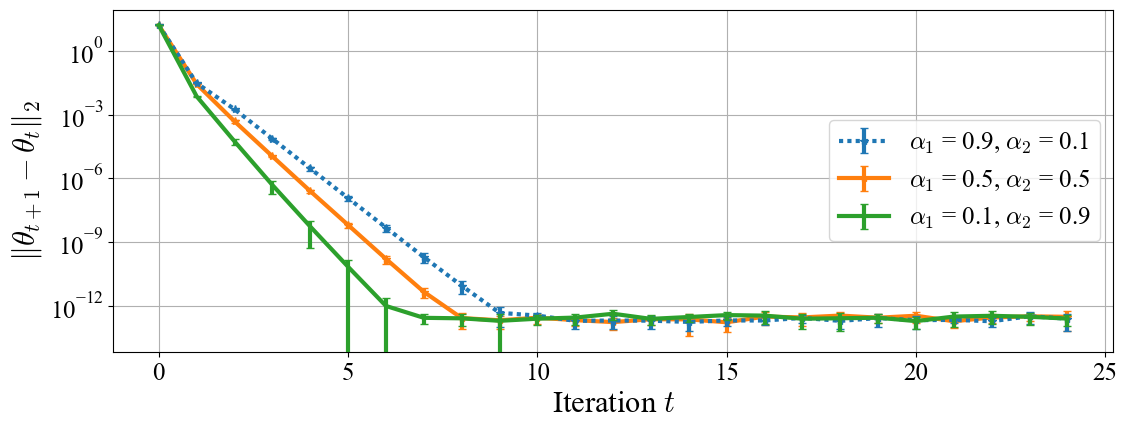

In [13]:
# compute mean and error bars over runs, ignoring zeros (treat zeros as NaN)
processed = np.load("theta_gaps.npy")
processed =  processed/strat_norm
for i, c in enumerate(list(range(num_eps))):

    legend_entry = '$\\alpha_1$ = {}'.format(Alpha_list[c][1]) + ', $\\alpha_2$ = {}'.format(Alpha_list[c][2])
    means = np.nanmean(processed[c], axis=0)  # shape (num_iters,)
    stds  = np.nanstd(processed[c], axis=0)
    x_all = np.arange(num_iters)
    mask = ~np.isnan(means)
    x = x_all[mask]
    y = means[mask]
    yerr = stds[mask]

    if i == 0:
        plt.errorbar(x, y, yerr=yerr, label=legend_entry, linewidth=3,  alpha=1, zorder=8,
                     marker='*', linestyle=(0, (1, 1)), capsize=3)
    elif i == 1:
        plt.errorbar(x, y, yerr=yerr, label=legend_entry, linewidth=3,  alpha=1,
                     marker='*', linestyle='solid', capsize=3)
    elif i == 2:
        plt.errorbar(x, y, yerr=yerr, label=legend_entry, linewidth=3, alpha=1, zorder=10,
                     capsize=3)
    else:
         plt.errorbar(x, y, yerr=yerr, label=legend_entry, linewidth=3, alpha=.6, capsize=3)


fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.xlabel('Iteration $t$',fontsize=22)
plt.ylabel(r'$ \|\theta_{t+1} - \theta_{t}\|_2 $', fontsize=22)
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(loc='center right', fontsize=18)
plt.grid()
plt.tight_layout(pad = 1.1)
plt.savefig("parameter-change.pdf")
plt.savefig("parameter-change.png")
print(stds)

In [21]:
np.save("theta_gaps.npy", processed)

In [24]:
processed

array([[[1.54821312e+00, 2.98240165e-03, 1.99245879e-04, 9.30931444e-06,
         4.41079549e-07, 2.09454687e-08, 9.94801404e-10, 4.71098302e-11,
         2.40437313e-12, 1.31701297e-13, 4.34322448e-14, 2.21541527e-14,
         1.08717270e-14, 2.00872659e-14, 2.05526465e-14, 2.03913670e-14,
         2.33324715e-14, 2.41760993e-14, 1.41893747e-14, 7.97727689e-15,
         6.54614593e-15, 2.62713261e-14, 1.22251891e-14, 1.94451270e-14,
         1.99982273e-14],
        [1.54825273e+00, 2.92923600e-03, 1.68906466e-04, 6.58689228e-06,
         2.50336358e-07, 9.51207773e-09, 3.61376728e-10, 1.37485209e-11,
         5.54705369e-13, 2.98365378e-14, 3.83397225e-14, 3.34145814e-14,
         2.11952610e-14, 1.62010587e-14, 1.71215360e-14, 3.87611718e-14,
         2.06551349e-14, 3.34653694e-14, 3.89585030e-14, 6.10011839e-14,
         2.12238067e-14, 2.64442888e-14, 6.53697837e-15, 6.88927483e-14,
         4.44719614e-14],
        [1.54820008e+00, 2.96224891e-03, 1.82929502e-04, 7.81746292e-06,

### Helper function: Training routine

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.utils.extmath import randomized_svd    # fast spectral-norm helper
import numpy as np

def train_lr_sklearn_lbfgs(X, y, lam, max_iter= 1000):
    """
    Fit ℓ₂-regularised logistic regression with scikit-learn.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
    y : ndarray, shape (n_samples,)
    lam : float
        Ridge-style regularisation weight (identical to `lam`
        in your original code).  scikit-learn expects `C = 1/lam`.
    max_iter : int
        Maximum BFGS iterations.

    Returns
    -------
    theta     : ndarray, shape (n_features,)
    ll        : float
        Negative log-likelihood *including* the ℓ₂ penalty, averaged per sample
        (matches what your original helper returned).
    L_smooth  : float
        Lipschitz constant of the logistic loss gradient,
        ‖X‖₂² ⁄ 4, identical to the old `logistic_smoothness`.
    """
    # scikit-learn needs labels {0,1}
    y = y.ravel().astype(int)

    clf = LogisticRegression(
        penalty      = 'l2',
        fit_intercept= False,
        max_iter     = max_iter,
        warm_start   = False,        # scikit-learn cannot accept explicit θ₀
        n_jobs       = -1,
        tol          = 1e-5
    )
    clf.fit(X, y)
    theta = clf.coef_.ravel()

    # --- log-likelihood (negative, per sample) --------------------------------
    p = clf.predict_proba(X)[:, 1]
    eps = np.finfo(float).eps       # numeric safety
    nll = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
    ll = nll + 0.5 * lam * np.sum(theta ** 2)   # add ℓ₂ penalty

    # --- smoothness of ∇ℓ (spectral norm of X) --------------------------------
    # fast, accurate spectral norm via 1-step randomized SVD
    _, s, _ = randomized_svd(X, n_components=1)
    L_smooth = (s[0] ** 2) / 4.0

    return theta, ll, L_smooth

In [ ]:
#sklearn backup:

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.utils.extmath import randomized_svd    # fast spectral-norm helper
import numpy as np

def train_lr_sklearn(X, y, lam, max_iter= 10000, lr = 0.01):
    """
    Fit ℓ₂-regularised logistic regression with scikit-learn.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
    y : ndarray, shape (n_samples,)
    lam : float
        Ridge-style regularisation weight (identical to `lam`
        in your original code).  scikit-learn expects `C = 1/lam`.
    max_iter : int
        Maximum BFGS iterations.

    Returns
    -------
    theta     : ndarray, shape (n_features,)
    ll        : float
        Negative log-likelihood *including* the ℓ₂ penalty, averaged per sample
        (matches what your original helper returned).
    L_smooth  : float
        Lipschitz constant of the logistic loss gradient,
        ‖X‖₂² ⁄ 4, identical to the old `logistic_smoothness`.
    """
    # scikit-learn needs labels {0,1}
    y = y.ravel().astype(int)

    clf = SGDClassifier(
        loss         = 'log_loss',
        penalty      = 'l2',
        fit_intercept= False,
        max_iter     = max_iter,
        warm_start   = False,        # scikit-learn cannot accept explicit θ₀
        n_jobs       = -1,
        tol          = 1e-5,
        learning_rate = 'constant',
        eta0 = lr
    )
    clf.fit(X, y)
    theta = clf.coef_.ravel()

    # --- log-likelihood (negative, per sample) --------------------------------
    p = clf.predict_proba(X)[:, 1]
    eps = np.finfo(float).eps       # numeric safety
    nll = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
    ll = nll + 0.5 * lam * np.sum(theta ** 2)   # add ℓ₂ penalty

    # --- smoothness of ∇ℓ (spectral norm of X) --------------------------------
    # fast, accurate spectral norm via 1-step randomized SVD
    _, s, _ = randomized_svd(X, n_components=1)
    L_smooth = (s[0] ** 2) / 4.0
    print("lr" + str(lr))
    return theta, ll, L_smooth
def utility(x, x_ori, theta):
    return -np.inner(x, theta)- (1/(2*eps))*np.linalg.norm(x - x_ori)**2

In [7]:
def train_lr_sklearn_accurate(X, y, lam, max_iter= 1000):
    """
    Fit ℓ₂-regularised logistic regression with scikit-learn.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
    y : ndarray, shape (n_samples,)
    lam : float
        Ridge-style regularisation weight (identical to `lam`
        in your original code).  scikit-learn expects `C = 1/lam`.
    max_iter : int
        Maximum BFGS iterations.

    Returns
    -------
    theta     : ndarray, shape (n_features,)
    ll        : float
        Negative log-likelihood *including* the ℓ₂ penalty, averaged per sample
        (matches what your original helper returned).
    L_smooth  : float
        Lipschitz constant of the logistic loss gradient,
        ‖X‖₂² ⁄ 4, identical to the old `logistic_smoothness`.
    """
    # scikit-learn needs labels {0,1}
    y = y.ravel().astype(int)

    clf = SGDClassifier(
        loss         = 'log_loss',
        penalty      = 'l2',
        fit_intercept= False,
        max_iter     = max_iter,
        warm_start   = False,        # scikit-learn cannot accept explicit θ₀
        n_jobs       = -1,
        tol          = 1e-5,
        learning_rate = 'optimal'
    )
    clf.fit(X, y)
    theta = clf.coef_.ravel()

    # --- log-likelihood (negative, per sample) --------------------------------
    p = clf.predict_proba(X)[:, 1]
    eps = np.finfo(float).eps       # numeric safety
    nll = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
    ll = nll + 0.5 * lam * np.sum(theta ** 2)   # add ℓ₂ penalty

    # --- smoothness of ∇ℓ (spectral norm of X) --------------------------------
    # fast, accurate spectral norm via 1-step randomized SVD
    _, s, _ = randomized_svd(X, n_components=1)
    L_smooth = (s[0] ** 2) / 4.0
    return theta, ll, L_smooth

### Simulation on the utilities of different levels of thinkers

In [21]:
theta_list         = [[np.copy(theta_true)] for _ in range(num_eps)]
theta_gaps         = [[] for _ in range(num_eps)]
ll_list            = [[] for _ in range(num_eps)]
acc_list_start     = [[] for _ in range(num_eps)]
acc_list_end       = [[] for _ in range(num_eps)]
lp_list_start      = [[] for _ in range(num_eps)]
lp_list_end        = [[] for _ in range(num_eps)]
condition_num_list = [[] for _ in range(num_eps)]
gd_cutoff_list     = [[] for _ in range(num_eps)]

n_runs = 10
alpha = [0, 0.5, 0.5]
rec_dict = {}
for run in range(n_runs):
    u1_list = []
    u2_list = []
    # initial theta
    theta = np.random.randn(np.shape(theta_true)[0])
    theta_copy = np.random.randn(np.shape(theta)[0])

    print('Running alpha =  {}\n'.format(alpha))
    agent_ind = split_ind(n, alpha)
    ind1 = agent_ind[1][0]
    ind2 = agent_ind[2][0]
    X[ind2,:] = np.zeros(X.shape[1])
    X[ind1,:] = X[ind2,:].copy()
    Y[ind1] = Y[ind2].copy()
    print(X[ind1,:], X[ind2,:])
    print(Y[ind1], Y[ind2])
    eps = 0.5
    X_strat = X.copy()
    num_iters = 25

    for t in range(num_iters):
        X_strat_copy = X_strat.copy()
        for i in range(1, len(alpha)):
            X_strat_copy = best_response(X, theta_copy, eps, strat_features)
            X_strat[agent_ind[i]] = X_strat_copy[agent_ind[i]]
            #print(theta_copy)
            if i < len(alpha)-1:
                #theta_init = np.copy(theta_true)
                theta_copy, ll, logistic_smoothness = train_lr_sklearn_lbfgs(X, Y, lam)
        u1_list.append(utility(X_strat[ind1], np.zeros(X.shape[1]), theta_copy))
        u2_list.append(utility(X_strat[ind2], np.zeros(X.shape[1]), theta_copy))
            
        
        # evaluate initial loss on the current distribution
        # performative loss value of previous theta
        loss_start = evaluate_loss(X_strat, Y, theta, lam, strat_features)
        acc = ((X_strat.dot(theta) > 0) == Y).mean()

        
        # learn on induced distribution
        theta_init = np.copy(theta_true)
        
        theta_new, ll, logistic_smoothness = train_lr_sklearn_lbfgs(X_strat, Y, lam)
        theta_copy = np.copy(theta_new)

        
        smoothness = max(logistic_smoothness + lam, 2) # lipschitz gradient
        


        # evaluate final loss on the current distribution
        loss_end = evaluate_loss(X_strat, Y, theta_new, lam, strat_features)
        acc = ((X_strat.dot(theta_new) > 0) == Y).mean()

        
        theta = np.copy(theta_new)
        print(loss_start - loss_end)
    u1_rec_str = "u1_" + str(run)
    u2_rec_str = "u2_" + str(run)

    rec_dict[u1_rec_str] = u1_list
    rec_dict[u2_rec_str] = u2_list

Running alpha =  [0, 0.5, 0.5]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 0
1.0460857538529722
0.00010095860086567487
-1.2150741524052933e-09
-1.404121263703928e-11
6.38378239159465e-14
-4.440892098500626e-16
-1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Running alpha =  [0, 0.5, 0.5]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 0
0.9141242963368167
0.00030202649429522666
4.200865277859123e-08
-2.962297074304843e-11
-7.297495940861154e-13
-5.551115123125783e-15
-1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
1.1102230246251565e-16
0.0
0.0
0.0
0.0
-1.1102230246251565e-16
1.1102230246251565e-16
0.0
-1.1102230246251565e-16
1.1102230246251565e-16
0.0
-1.1102230246251565e-16
1.1102230246251565e-16
Running alpha =  [0, 0.5, 0.5]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 1
0.21351213908013134
8.650673946231091e-05
-4.459856928207273e-10
8.795408845685415e-12
-

### Result retrieval

In [22]:
import pandas as pd
df_utility_k_level = pd.DataFrame(rec_dict)
df_utility_k_level.to_csv("util_k_level.csv")

In [268]:
#print(theta_gaps)
import pandas as pd
pd.DataFrame(np.array(u2_list)- np.array(u1_list)).mean()

0     7.201078e-01
1     4.519804e-05
2     9.612391e-09
3     2.137139e-09
4     2.879756e-09
5     2.176831e-09
6     2.878399e-09
7     2.176862e-09
8     2.878399e-09
9     2.176862e-09
10    2.878399e-09
11    2.176862e-09
12    2.878399e-09
13    2.176862e-09
14    2.878399e-09
15    2.176862e-09
16    2.878399e-09
17    2.176862e-09
18    2.878399e-09
19    2.176862e-09
20    2.878399e-09
21    2.176862e-09
22    2.878399e-09
23    2.176862e-09
24    2.878399e-09
dtype: float64